# Gaussian process + HMC
Investigations into and implementation of the paper by Rasmussen:

http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2080.pdf


## Gaussian processes
A simple example with the sklearn interface

Prior kernel: 1**2 * RBF(length_scale=10)
MLE kernel  : 4.96**2 * RBF(length_scale=1.8)


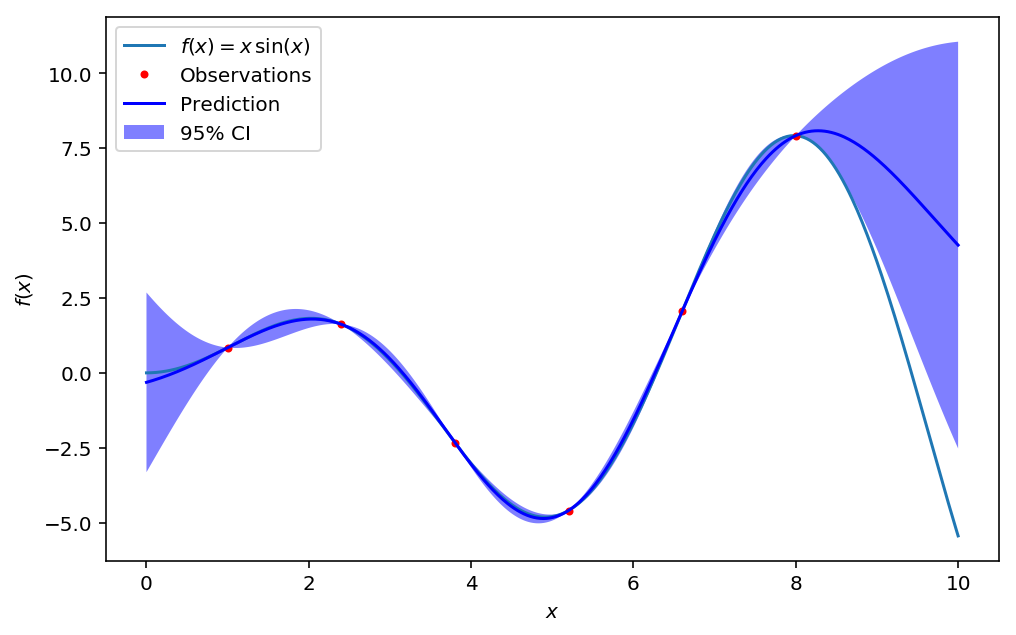

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel


def f_target(x):
    return x * np.sin(x)


def _reshapex(x):
    ''' Reshape an x value to include a second dimension '''
    assert len(x.shape) == 1
    return x.reshape((x.shape[0], 1))


# The points and values which we have sampled
x = np.linspace(1, 8, 6)
y = f_target(x)

# Fit a gaussian process
# The tuples in the arguments to the kernels indicate the valid range of the parameters
# when calling 'fit'
kernel = ConstantKernel(1, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
print('Prior kernel:', kernel)

# n_restarts_optimizer is trying to avoid getting stuck in a local minimum when looking for
# hyperparameter values. If the hyperparameters were set *exactly*, then this could be left
# at the default value, which is 0.
regressor = GaussianProcessRegressor(kernel, n_restarts_optimizer=20)
regressor.fit(_reshapex(x), y)
print('MLE kernel  :', regressor.kernel_)


# Evaluate our GP at many more points - include the uncertainty at every point
x_eval = np.linspace(0, 10, 500)
y_eval, sigma_eval = regressor.predict(_reshapex(x_eval), return_std=True)

plt.figure(figsize=(8, 5))
plt.plot(x_eval, f_target(x_eval), label=r'$f(x) = x\,\sin(x)$')
plt.plot(x, y, 'r.', label='Observations')
plt.plot(x_eval, y_eval, 'b-', label='Prediction')
plt.fill(np.concatenate([x_eval, x_eval[::-1]]),
         np.concatenate([(y_eval - 1.96 * sigma_eval),
                         (y_eval + 1.96 * sigma_eval)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% CI')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend();

In order to do HMC on a function, we need to compute derivatives. First let's check that we can map terms from the GP regressor to things that are described in the paper. It looks like "kernel\_" is a callable that computes the covariance function, and "alpha\_" is a constant which corresponds to $C(x, x)^{-1}y$, referring to equation (5) in the paper.

In [3]:
# This is how we get the C(x^*, x) term.
# cov = regressor.kernel_(_reshapex(x_eval), _reshapex(x)).shape

cov_xx = regressor.kernel_(_reshapex(x), _reshapex(x))

# x & y are also available from the regressor as x_train and y_train
alpha2 = np.linalg.inv(cov_xx).dot(y)

# We are just trying to show that these two things are equivalent
print(regressor.alpha_)
print(alpha2)

[-0.09474853  0.1047566   0.35341092 -0.87569892  0.45340529  0.2244382 ]
[-0.09474853  0.1047566   0.35341092 -0.87569892  0.45340529  0.2244382 ]


Good, so now we need to compute, from equation (7):

$$ \mathbb{E}\left[\frac{\partial y^*}{\partial x^*_d} \right] = \frac{\partial C(x^*, x)}{\partial x^*_d} C(x, x)^{-1} y. $$

In [4]:
from pypuffin.plaintext import instance_to_string

const_kernel = regressor.kernel_.k1
rbf_kernel = regressor.kernel_.k2
print(instance_to_string(const_kernel, include_type_properties=True))
print(instance_to_string(rbf_kernel, include_type_properties=True))

ConstantKernel<
  bounds: array([[-6.90775528,  6.90775528]]),
  constant_value: 24.578189821492046,
  constant_value_bounds: (0.001, 1000.0),
  hyperparameter_constant_value: Hyperparameter(name='constant_value', value_type='numeric', bounds=array([[  1.00000000e-03,   1.00000000e+03]]), n_elements=1, fixed=False),
  hyperparameters: [Hyperparameter(name='constant_value', value_type='numeric', bounds=array([[  1.00000000e-03,   1.00000000e+03]]), n_elements=1, fixed=False)],
  n_dims: 1,
  theta: array([ 3.20185946]),
>
RBF<
  anisotropic: False,
  bounds: array([[-4.60517019,  4.60517019]]),
  hyperparameter_length_scale: Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[  1.00000000e-02,   1.00000000e+02]]), n_elements=1, fixed=False),
  hyperparameters: [Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[  1.00000000e-02,   1.00000000e+02]]), n_elements=1, fixed=False)],
  length_scale: 1.801938409454183,
  length_scale_bounds: (0.01, 10

In [22]:
print(instance_to_string(regressor))

GaussianProcessRegressor<
  L_: array([[  4.95763954e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.66603610e+00,   3.33741953e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.48238874e+00,   3.81743882e+00,   2.79425738e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.27771401e-01,   1.84200014e+00,   3.81399299e+00,
          2.55563078e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.96299559e-02,   4.43362783e-01,   2.00335580e+00,
          3.79727648e+00,   2.43870981e+00,   0.00000000e+00],
       [  2.62011105e-03,   5.59910472e-02,   5.03656553e-01,
          2.08332604e+00,   3.78478367e+00,   2.37834884e+00]]),
  X_train_: array([[ 1. ],
       [ 2.4],
       [ 3.8],
       [ 5.2],
       [ 6.6],
       [ 8. ]]),
  alpha: 1e-10,
  alpha_: array([-0.09474853,  0.1047566 ,  0.35341092, -0.87569892,  0.45340529,
        0.2244

In [5]:
X_eval = _reshapex(x_eval)
X = _reshapex(x)

In [6]:
# This is the different between each evaluation point and each training point, in a vector sense. It is therefore
# a three-component tensor.
# (n_eval, n_train, dim)
x_twiddle = X_eval[:, np.newaxis, :] - X[np.newaxis, :, :]
print(x_twiddle.shape)

# kernel(X_eval, X) --> shape of (n_eval, n_train)
print(rbf_kernel(X_eval, X).shape)

# Therefore the gradient, which looks at the derivative of each component of this covariance matrix to the 
# *corresponding* evaluation vector's coordinates, should have shape
# (n_eval, n_train, dim)
rbf_kernel_derivative = - (1 / rbf_kernel.length_scale ** 2) * x_twiddle * rbf_kernel(X_eval, X)[:, :, np.newaxis]
print(rbf_kernel_derivative.shape)

# Let's just check that this seems like a plausible value for the derivative with a finite-difference approximation
dx = 1e-6
approx_deriv = (rbf_kernel(X_eval + dx, X) - rbf_kernel(X_eval, X)) / dx
print(approx_deriv[0])
print(rbf_kernel_derivative[0].flatten())

(500, 6, 1)
(500, 6)
(500, 6, 1)
[  2.64023952e-01   3.04454217e-01   1.26650019e-01   2.48988610e-02
   2.48266499e-03   1.29272396e-04]
[  2.64024043e-01   3.04454168e-01   1.26649962e-01   2.48988435e-02
   2.48266266e-03   1.29272244e-04]


In [12]:
kernel_derivative = const_kernel.constant_value * rbf_kernel_derivative
print(kernel_derivative.shape)

(500, 6, 1)


This means we have foun the term $\frac{\partial C(x^*, x)}{\partial x^*_d}$ All that is left is to multiply through by $\alpha = C(x, x)^{-1} y. $ As seen below, $\alpha$ has shape (n_train,), so we need to broadcast manually in the appropriate directions.

In [27]:
print(regressor.alpha_.shape)

#
gradient = np.sum(kernel_derivative * regressor.alpha_[np.newaxis, :, np.newaxis], axis=1)
gradient_2 = np.tensordot(kernel_derivative, regressor.alpha_, (1, 0))
print(gradient.shape)
print(np.allclose(gradient, gradient_2))

# We should now be the same as using the 'proper' pushed implementation
from pypuffin.sklearn.gaussian_process import gradient_of_mean

gradient_3 = gradient_of_mean(regressor, X_eval)
print(np.allclose(gradient, gradient_3))

(6,)
(500, 1)
True
True


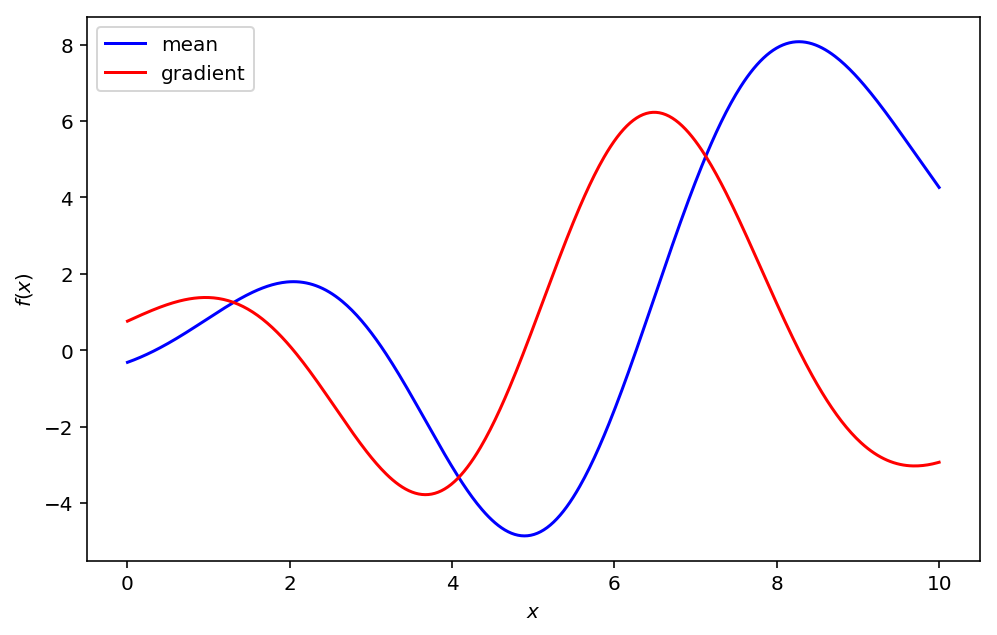

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(x_eval, y_eval, 'b-', label='mean')
plt.plot(x_eval, gradient_3.flatten(), 'r-', label='gradient')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend();

# TODO
* Implement basic HMC

HMC algorithm - described originally (and well) here:

https://arxiv.org/pdf/1206.1901.pdf